In [1]:
# for vectorized operations
import numpy as np

# for dataframe manipulation
import pandas as pd

# for vizualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for statistical calculations
import scipy.stats as stats

# for obtaining stock datasets
from pydataset import data

# for manipulation of time data
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import sklearn as sk

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



# filter out warnings
import warnings
warnings.filterwarnings('ignore')

# our own functions for accessing our sql database
from env import get_db_url, user, password, host

# our own scripts
import acquire
import prepare
import explore

# pandas display preferences
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
pd.set_option('display.precision', 2)
#pd.option_context('display.max_rows', None)

import os
import math
import itertools

In [2]:
# define a function for obtaining Telco Customer Data
def get_telco_data():
    
    filename = 'telco_churn.csv'
    
    # check for existing csv file in local directory
    # if it exists, return it as a datframe
    if os.path.exists(filename):
        print('Reading from local CSV...')
        return pd.read_csv(filename)
    
    # if no local directory exists, query the codeup SQL database 
    
    # utilize function defined in env.py to define the url
    url = get_db_url('telco_churn')
    
    # join the customer, contract_types, internet_service_types, and payment_types tables
    sql = '''
    SELECT * 
      FROM customers
        JOIN contract_types USING(contract_type_id)
        JOIN internet_service_types USING(internet_service_type_id)
        JOIN payment_types USING(payment_type_id)
    '''
    
    # return  the results of the query as a dataframe
    print('No local file exists\nReading from SQL database...')
    df = pd.read_sql(sql, url)
    
    # save the dataframe to the local directory as a CSV for future ease of access
    print('Saving to local CSV...')
    df.to_csv(filename, index=False)
    
    # return the dataframe
    return df

In [3]:
# utilize the get_telco_data() function to create a dataframe of customer data
df = get_telco_data()

Reading from local CSV...


# Prepare

In [4]:
# preview the dataframe
df.head(3)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,No,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,Yes,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [6]:
df.shape

(7043, 24)

In [7]:
# drop duplicate rows, if present
df = df.drop_duplicates()

In [8]:
# clean up total_charges column and cast as float
df['total_charges'] = df.total_charges.replace(' ', np.nan).astype(float)

In [9]:
# check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

we can see that there are eleven null values in the total_charges column. Perhaps these are brand new customers? We can remove brand new customers since they are not relevant to a study of churn. 

In [10]:
# removing brand new customers
df = df[df.tenure != 0]

In [11]:
# check for nulls again - no longer any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7032 non-null   int64  
 1   internet_service_type_id  7032 non-null   int64  
 2   contract_type_id          7032 non-null   int64  
 3   customer_id               7032 non-null   object 
 4   gender                    7032 non-null   object 
 5   senior_citizen            7032 non-null   int64  
 6   partner                   7032 non-null   object 
 7   dependents                7032 non-null   object 
 8   tenure                    7032 non-null   int64  
 9   phone_service             7032 non-null   object 
 10  multiple_lines            7032 non-null   object 
 11  online_security           7032 non-null   object 
 12  online_backup             7032 non-null   object 
 13  device_protection         7032 non-null   object 
 14  tech_sup

In [12]:
# drop any unneccessary, unhelpful, or duplicated columns. 
# type_id columns are simply foreign key columns that have corresponding string values
# customer_id is a primary key that is not useful for our analysis
# total_charges is essentially a function of monthly_charges * tenure
df = df.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id', 'total_charges'])

In [13]:
# change senior citizen to object types Yes/No for exploration purposes
df['senior_citizen'] = df.senior_citizen.map({1: 'Yes', 0: 'No'})

In [14]:
# add a feature: tenure by quarters
df['tenure_quarters'] = df.tenure.apply(lambda months: math.ceil(months / 3))

# add a feature: tenure by years
df['tenure_years'] = df.tenure.apply(lambda months: math.ceil(months / 12))

# rename tenure columns
df = df.rename(columns={'tenure': 'tenure_months'})

In [15]:
df.dtypes

gender                    object
senior_citizen            object
partner                   object
dependents                object
tenure_months              int64
phone_service             object
multiple_lines            object
online_security           object
online_backup             object
device_protection         object
tech_support              object
streaming_tv              object
streaming_movies          object
paperless_billing         object
monthly_charges          float64
churn                     object
contract_type             object
internet_service_type     object
payment_type              object
tenure_quarters            int64
tenure_years               int64
dtype: object

In [16]:
# define categorical columns
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
categorical_columns

['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type']

In [17]:
# one-hot encoding those columns
for col in categorical_columns:
    dummy_df = pd.get_dummies(df[col],
                              prefix=f'enc_{df[col].name}',
                              drop_first=True,
                              dummy_na=False)
    
    # add the columns to the dataframe
    df = pd.concat([df, dummy_df], axis=1)
    
# clean up the column names
for col in df.columns:
    df = df.rename(columns={col: col.lower()})
    df = df.rename(columns={col: col.replace(' ', '_')})
df = df.rename(columns={'enc_churn_yes': 'enc_churn'})

In [18]:
# utilizing the function defined in prepare.py, split the data into train, test, and validate samples
train, test, validate = prepare.train_test_validate_split(df, target='churn')

train	 n = 3937
test	 n = 1407
validate n = 1688


In [19]:
# define which column represents the target variable
# (churn Yes/No)
target = 'churn'

In [20]:
# preview the train sample
train.head(3)

,gender,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,churn,contract_type,internet_service_type,payment_type,tenure_quarters,tenure_years,enc_gender_male,enc_senior_citizen_yes,enc_partner_yes,enc_dependents_yes,enc_phone_service_yes,enc_multiple_lines_no phone service,enc_multiple_lines_yes,enc_online_security_no internet service,enc_online_security_yes,enc_online_backup_no internet service,enc_online_backup_yes,enc_device_protection_no internet service,enc_device_protection_yes,enc_tech_support_no internet service,enc_tech_support_yes,enc_streaming_tv_no internet service,enc_streaming_tv_yes,enc_streaming_movies_no internet service,enc_streaming_movies_yes,enc_paperless_billing_yes,enc_churn,enc_contract_type_one year,enc_contract_type_two year,enc_internet_service_type_fiber optic,enc_internet_service_type_none,enc_payment_type_credit card (automatic),enc_payment_type_electronic check,enc_payment_type_mailed check
1947,Female,No,Yes,Yes,37,Yes,Yes,No,No,No,No,Yes,Yes,Yes,95.25,No,Month-to-month,Fiber optic,Electronic check,13,4,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0
6613,Female,No,No,No,69,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,24.60,No,Two year,None,Credit card (automatic),23,6,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,0
6256,Female,No,No,No,72,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,111.60,No,Two year,Fiber optic,Bank transfer (automatic),24,6,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 1947 to 3806
Data columns (total 49 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   gender                                     3937 non-null   object 
 1   senior_citizen                             3937 non-null   object 
 2   partner                                    3937 non-null   object 
 3   dependents                                 3937 non-null   object 
 4   tenure_months                              3937 non-null   int64  
 5   phone_service                              3937 non-null   object 
 6   multiple_lines                             3937 non-null   object 
 7   online_security                            3937 non-null   object 
 8   online_backup                              3937 non-null   object 
 9   device_protection                          3937 non-null   object 
 10  tech_support         

In [22]:
# define categorical columns
categorical_columns = list(train.dtypes[train.dtypes == 'object'].index)
categorical_columns

['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type']

### Initial Exploration - Univariate

        gender_counts
Male             1987
Female           1950


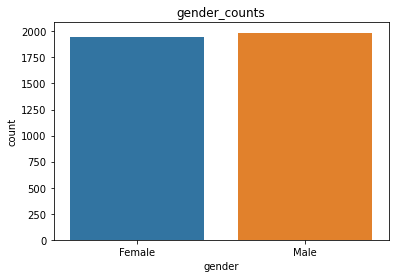

     senior_citizen_counts
No                    3312
Yes                    625


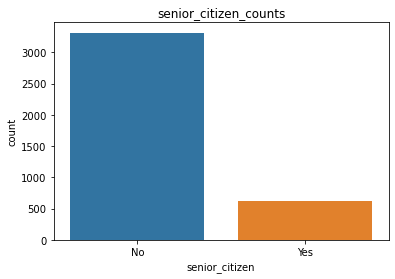

     partner_counts
No             2067
Yes            1870


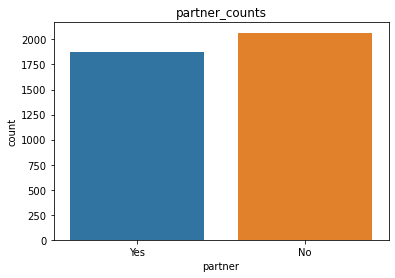

     dependents_counts
No                2764
Yes               1173


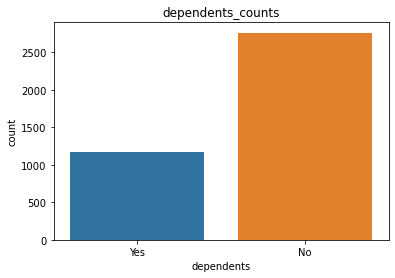

     phone_service_counts
Yes                  3542
No                    395


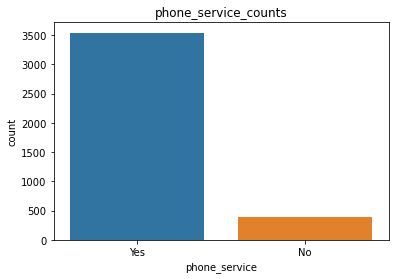

                  multiple_lines_counts
No                                 1858
Yes                                1684
No phone service                    395


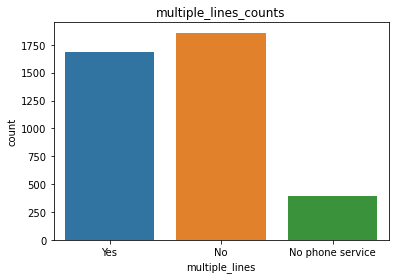

                     online_security_counts
No                                     1971
Yes                                    1147
No internet service                     819


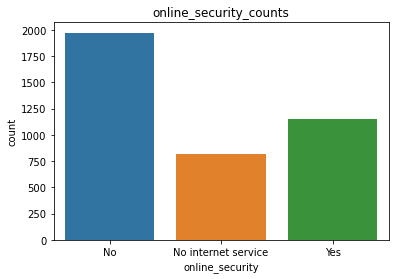

                     online_backup_counts
No                                   1761
Yes                                  1357
No internet service                   819


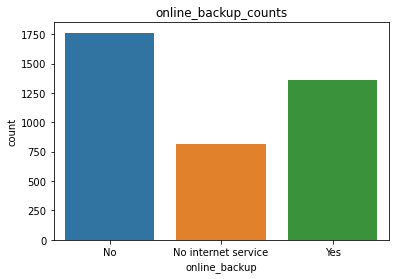

                     device_protection_counts
No                                       1776
Yes                                      1342
No internet service                       819


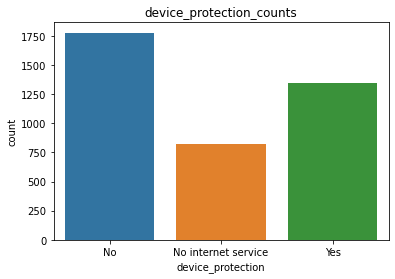

                     tech_support_counts
No                                  1978
Yes                                 1140
No internet service                  819


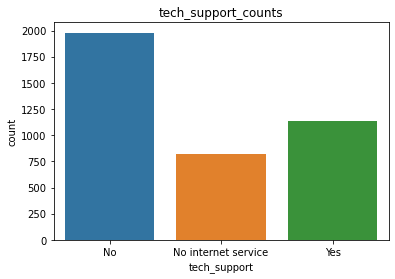

                     streaming_tv_counts
No                                  1602
Yes                                 1516
No internet service                  819


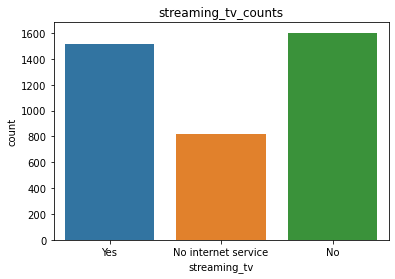

                     streaming_movies_counts
No                                      1585
Yes                                     1533
No internet service                      819


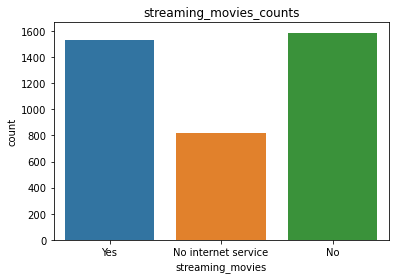

     paperless_billing_counts
Yes                      2368
No                       1569


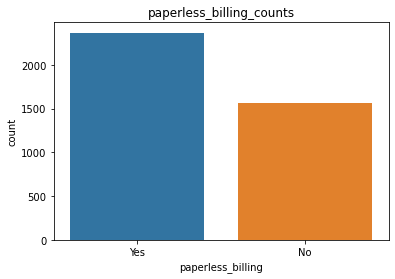

     churn_counts
No           2891
Yes          1046


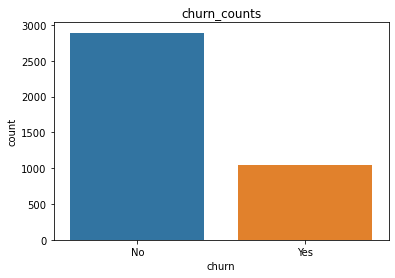

                contract_type_counts
Month-to-month                  2181
Two year                         924
One year                         832


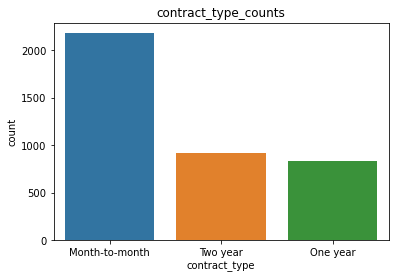

             internet_service_type_counts
Fiber optic                          1744
DSL                                  1374
None                                  819


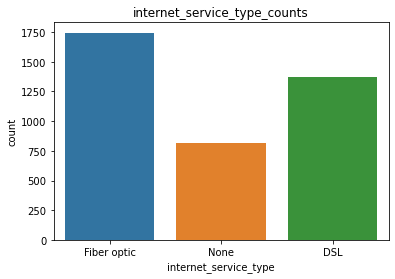

                           payment_type_counts
Electronic check                          1330
Mailed check                               906
Credit card (automatic)                    854
Bank transfer (automatic)                  847


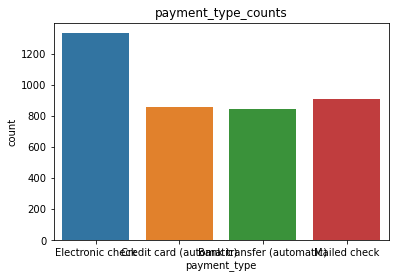

In [23]:
# for each of those columns
for col in categorical_columns:
    
    # display a frequency table
    print(pd.DataFrame(train[col].value_counts())
          .rename(columns={col: f'{col}_counts'}))
    
    # display a bar plot of those frequencies
    sns.countplot(data=train,
                  x=col)
    plt.title(f'{col}_counts')
    plt.show()

In [24]:
# define quantitative columns
quantitative_columns = ['monthly_charges', 'tenure_months']

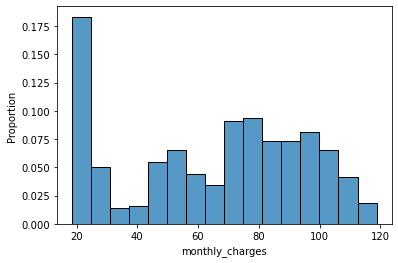

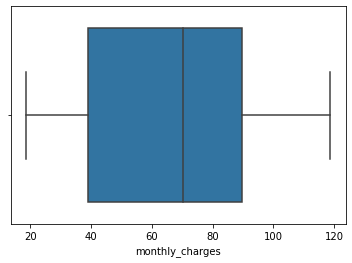

       monthly_charges
count          3937.00
mean             65.05
std              29.86
min              18.55
25%              38.90
50%              70.35
75%              89.80
max             118.75


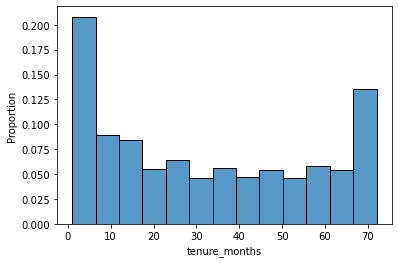

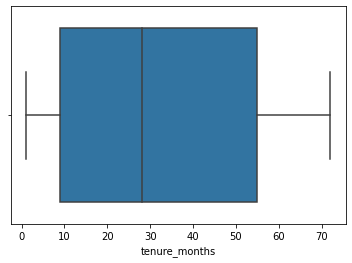

       tenure_months
count        3937.00
mean           32.18
std            24.60
min             1.00
25%             9.00
50%            28.00
75%            55.00
max            72.00


In [25]:
# for each of those columns:
for col in quantitative_columns:
        
        # display a histogram of that column's distribution
        sns.histplot(train[col], stat='proportion')
        plt.show()
        
        # display a boxplot of that column's distribution
        sns.boxplot(train[col])
        plt.show()
        
        # display the summary statistics of the distribution
        print(pd.DataFrame(train[col].describe()))

### Initial Exploration - Bivariate

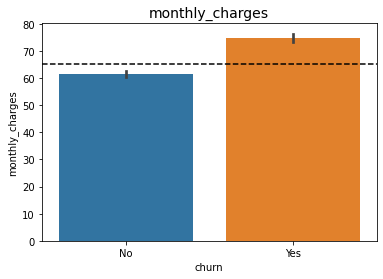

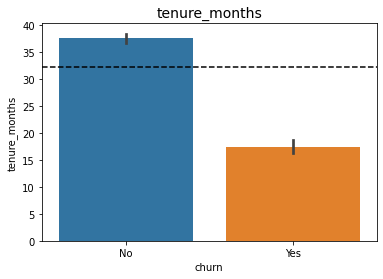

In [26]:
# for each of the quantitative columns
for col in quantitative_columns:
    # display a barplot of that variable for customers in each category of the target variable
    sns.barplot(data=train,
                x=target,
                y=col)
    # add a horizontal line representing the overall mean value for that variable
    plt.axhline(train[col].mean(), 
                ls='--', 
                color='black')
    plt.title(col, fontsize=14)
    plt.show()

### Initial Exploration - Multivariate

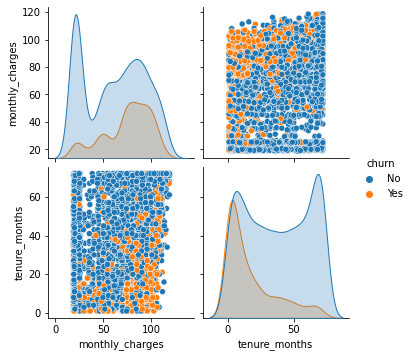

In [27]:
# create and display a pairplot comparing the distributions of each quantitative variable
    # in each category of the target variable
g = sns.pairplot(train[quantitative_columns + [target]], hue=target)
plt.show()

In [28]:
train.churn.map({'Yes': 1, 'No': 0})

1947    0
6613    0
6256    0
5070    0
67      1
       ..
719     0
5446    0
2764    1
3554    0
3806    0
Name: churn, Length: 3937, dtype: int64

In [29]:
### create some swarm plots or similar here

In [30]:
train

,gender,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,churn,contract_type,internet_service_type,payment_type,tenure_quarters,tenure_years,enc_gender_male,enc_senior_citizen_yes,enc_partner_yes,enc_dependents_yes,enc_phone_service_yes,enc_multiple_lines_no phone service,enc_multiple_lines_yes,enc_online_security_no internet service,enc_online_security_yes,enc_online_backup_no internet service,enc_online_backup_yes,enc_device_protection_no internet service,enc_device_protection_yes,enc_tech_support_no internet service,enc_tech_support_yes,enc_streaming_tv_no internet service,enc_streaming_tv_yes,enc_streaming_movies_no internet service,enc_streaming_movies_yes,enc_paperless_billing_yes,enc_churn,enc_contract_type_one year,enc_contract_type_two year,enc_internet_service_type_fiber optic,enc_internet_service_type_none,enc_payment_type_credit card (automatic),enc_payment_type_electronic check,enc_payment_type_mailed check
1947,Female,No,Yes,Yes,37,Yes,Yes,No,No,No,No,Yes,Yes,Yes,95.25,No,Month-to-month,Fiber optic,Electronic check,13,4,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0
6613,Female,No,No,No,69,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,24.60,No,Two year,None,Credit card (automatic),23,6,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,0
6256,Female,No,No,No,72,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,111.60,No,Two year,Fiber optic,Bank transfer (automatic),24,6,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0
5070,Female,No,No,No,17,Yes,Yes,No,No,Yes,No,No,No,No,80.05,No,Month-to-month,Fiber optic,Bank transfer (automatic),6,2,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
67,Male,No,Yes,No,49,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,No,84.35,Yes,One year,DSL,Electronic check,17,5,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,Female,No,Yes,Yes,56,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,109.60,No,Month-to-month,Fiber optic,Mailed check,19,5,0,0,1,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1
5446,Female,No,Yes,Yes,36,No,No phone service,Yes,No,Yes,Yes,No,No,No,40.65,No,Two year,DSL,Credit card (automatic),12,3,0,0,1,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
2764,Male,No,Yes,No,23,Yes,Yes,Yes,Yes,Yes,No,Yes,No,Yes,99.25,Yes,Month-to-month,Fiber optic,Electronic check,8,2,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0
3554,Female,No,No,No,56,Yes,Yes,No,Yes,Yes,No,Yes,Yes,Yes,106.80,No,One year,Fiber optic,Electronic check,19,5,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,0,1,0


In [31]:
# create dataframe of correlation values for target variable
train_correlations = pd.DataFrame(train.corr().enc_churn.sort_values())
# use the absolute values of the correlations in a new dataframe
train_corr_abs = pd.DataFrame(train_correlations.apply(lambda corr: abs(corr).sort_values(ascending=False)))

In [32]:
train_corr_abs

,enc_churn
enc_churn,1.00e+00
tenure_months,3.61e-01
tenure_quarters,3.59e-01
tenure_years,3.48e-01
enc_payment_type_electronic check,3.28e-01
enc_internet_service_type_fiber optic,3.10e-01
enc_contract_type_two year,3.01e-01
enc_internet_service_type_none,2.30e-01
enc_streaming_movies_no internet service,2.30e-01
enc_streaming_tv_no internet service,2.30e-01


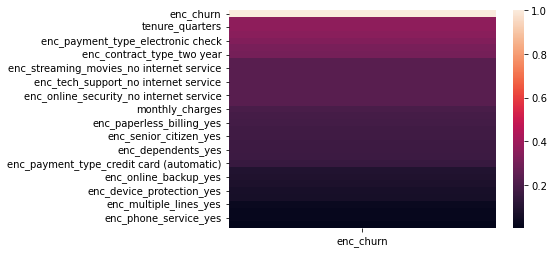

In [33]:
# display a heatmap of correlation values
sns.heatmap(train_corr_abs)
plt.show()

In [34]:
train_corr_abs

,enc_churn
enc_churn,1.00e+00
tenure_months,3.61e-01
tenure_quarters,3.59e-01
tenure_years,3.48e-01
enc_payment_type_electronic check,3.28e-01
enc_internet_service_type_fiber optic,3.10e-01
enc_contract_type_two year,3.01e-01
enc_internet_service_type_none,2.30e-01
enc_streaming_movies_no internet service,2.30e-01
enc_streaming_tv_no internet service,2.30e-01


### Further Exploration - Does demographic information affect churn?

In [35]:
# defining a function to encapsulate repeated code for chi2 tests:

def chi2_test(data_for_category1, data_for_category2, alpha=.05):
    
    # create dataframe of observed values
    observed = pd.crosstab(data_for_category1, data_for_category2)
    
    # conduct test using scipy.stats.chi2_contingency() test
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    
    # round the expected values
    expected = expected.round(1)
    
    # output
    print('Observed\n')
    print(observed.values)
    print('---\nExpected\n')
    print(expected)
    print('---\n')
    print(f'chi^2 = {chi2:.4f}')
    print(f'p     = {p:.4f}')
    
    # evaluate the hypothesis against the established alpha value
    if p < alpha:
        print('\nReject H0')
    else: 
        print('\nFail to Reject H0')

#### Is churn independent of gender?

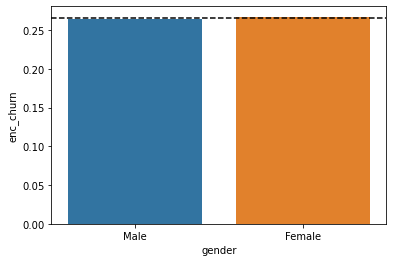

In [36]:
def churn_rate_by_gender():
    churn_rates = (pd.DataFrame(train.groupby(by='gender').mean().enc_churn)
                   .reset_index()
                   .sort_values(by='enc_churn'))
    sns.barplot(data = churn_rates,
                x = 'gender', 
                y = 'enc_churn')
    plt.axhline(train.enc_churn.mean(), 
                    ls='--', 
                    color='black')
    plt.show()
churn_rate_by_gender()

In [37]:
# establish hypotheses

# H0: Whether a customer has churned is independent of their gender
# H1: Whether a customer has churned is not independent of their gender

In [38]:
# run the test and display results
chi2_test(train.churn, train.gender)

Observed

[[1429 1462]
 [ 521  525]]
---
Expected

[[1431.9 1459.1]
 [ 518.1  527.9]]
---

chi^2 = 0.0304
p     = 0.8616

Fail to Reject H0


With a chi^2 p-value of .86, we fail to reject the null hypothesis, and we proceed under the assumption that whether a customer has churned is independent of their gender. 

#### Is churn independent of senior citizen status?

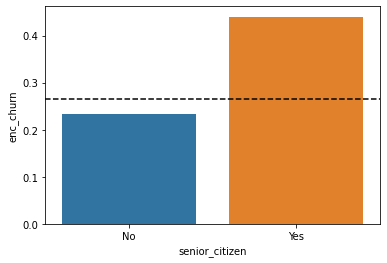

In [39]:
def churn_rate_by_senior():
    churn_rates = (pd.DataFrame(train.groupby(by='senior_citizen').mean().enc_churn)
                   .reset_index()
                   .sort_values(by='enc_churn'))
    sns.barplot(data = churn_rates,
                x = 'senior_citizen', 
                y = 'enc_churn')
    plt.axhline(train.enc_churn.mean(), 
                    ls='--', 
                    color='black')
    plt.show()
churn_rate_by_senior()

In [40]:
# establish hypotheses

# H0: Whether a customer has churned is independent of whether they are a senior citizen
# H1: Whether a customer has churned is not independent of whether they are a senior citizen

In [41]:
# run the test and display results
chi2_test(train.churn, train.senior_citizen)

Observed

[[2541  350]
 [ 771  275]]
---
Expected

[[2432.1  458.9]
 [ 879.9  166.1]]
---

chi^2 = 114.6522
p     = 0.0000

Reject H0


With a p-value of virtually 0.00, we reject the null hypothesis, and we proceed under the assumption that whether a customer has churned is not independent of whether they are a senior citizen. 

#### Is churn independent of whether a customer has a partner?

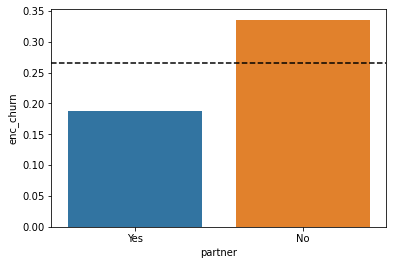

In [42]:
def churn_rate_by_partner(train):
    churn_rates = (pd.DataFrame(train.groupby(by='partner').mean().enc_churn)
                   .reset_index()
                   .sort_values(by='enc_churn'))
    sns.barplot(data = churn_rates,
                x = 'partner', 
                y = 'enc_churn')
    plt.axhline(train.enc_churn.mean(), 
                    ls='--', 
                    color='black')
    plt.show()
churn_rate_by_partner(train)

In [43]:
# establish hypotheses

# H0: Whether a customer has churned is independent of whether they have a partner
# H1: Whether a customer has churned is not independent of whether they have a partner

In [44]:
# run the test and display results
chi2_test(train.churn, train.partner)

Observed

[[1373 1518]
 [ 694  352]]
---
Expected

[[1517.8 1373.2]
 [ 549.2  496.8]]
---

chi^2 = 108.7547
p     = 0.0000

Reject H0


With a p-value of virtually 0.00, we reject the null hypothesis, and we proceed under the assumption that whether a customer has churned is not independent of whether they have a partner. 

#### Is churn independent of whether a customer has dependents?

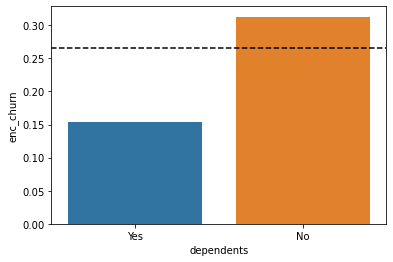

In [45]:
def churn_rate_by_dependents(train):
    churn_rates = (pd.DataFrame(train.groupby(by='dependents').mean().enc_churn)
                   .reset_index()
                   .sort_values(by='enc_churn'))
    sns.barplot(data = churn_rates,
                x = 'dependents', 
                y = 'enc_churn')
    plt.axhline(train.enc_churn.mean(), 
                    ls='--', 
                    color='black')
    plt.show()
churn_rate_by_dependents(train)

In [46]:
# establish hypotheses

# H0: Whether a customer has churned is independent of whether they have dependents
# H1: Whether a customer has churned is not independent of whether they have dependents

In [47]:
# run the test and display results
chi2_test(train.churn, train.partner)

Observed

[[1373 1518]
 [ 694  352]]
---
Expected

[[1517.8 1373.2]
 [ 549.2  496.8]]
---

chi^2 = 108.7547
p     = 0.0000

Reject H0


With a p-value of virtually 0.00, we reject the null hypothesis, and we proceed under the assumption that whether a customer has churned is not independent of whether they have dependents.

### Further Exploration - Do customers who churn have higher average monthly charges than those who don't?

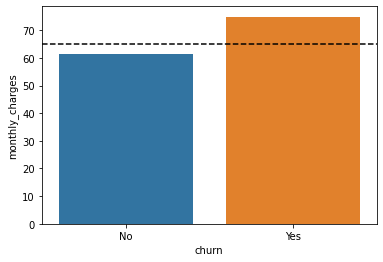

In [50]:
def monthly_charges_by_churn(train):
    charges = (pd.DataFrame(train.groupby(by='churn').monthly_charges.mean())
                   .reset_index())
    sns.barplot(data = charges,
                x = 'churn', 
                y = 'monthly_charges')
    plt.axhline(train.monthly_charges.mean(), 
                    ls='--', 
                    color='black')
    plt.show()
monthly_charges_by_churn(train)

In [42]:
# establish hypotheses

# H0: Average monthly charges is the same for customers who have churned and those who have not
# H1: Average monthly charges are higher for customers who have churned than for those who have not

In [43]:
# get the data
train_churned = train[train.churn == 'Yes']
train_not_churned = train[train.churn == 'No']


Churn-Yes n:  1046
Churn-Yes distribution:


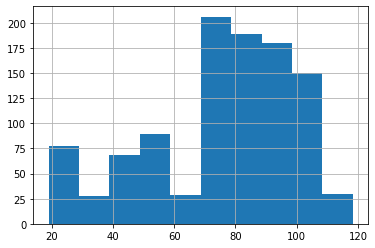


Churn-No n:  2891
Churn-No distribution:


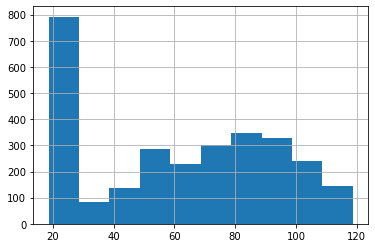

Churn-Yes variance:  585.3265375890841
Churn-No variance:  954.8247252815352
LeveneResult(statistic=211.4475841287422, pvalue=1.058116304873605e-46)


In [44]:
# confirm assumptions

# independent? - yes (not possible for one customer to be in both groups)

# approximates a normal distribution? - No (see below)
    # due to large concentration of observations on the left side of the churn-no distribution,
    # we will not assume normality for this test. 
    
# equal variances? - no (see below)

print('\nChurn-Yes n: ', train_churned.monthly_charges.shape[0])
print('Churn-Yes distribution:')
train_churned.monthly_charges.hist()
plt.show()

print('\nChurn-No n: ', train_not_churned.monthly_charges.shape[0])
print('Churn-No distribution:')
train_not_churned.monthly_charges.hist()
plt.show()


print('Churn-Yes variance: ', train_churned.monthly_charges.var())
print('Churn-No variance: ', train_not_churned.monthly_charges.var())

print(stats.levene(train_churned.monthly_charges, train_not_churned.monthly_charges))

In [45]:
# conduct the test and display results

# Mann Whitney U test

# establish hypothesis and alpha level
H0 = f'mean monthly_charges for customers who have churned <= mean monthly charges for those who have not churned'
H1 = f'mean monthly_charges for customers who have churned > mean monthly charges for those who have not churned'
alpha = .05

# conduct the test
u, p = stats.mannwhitneyu(train_churned.monthly_charges, train_not_churned.monthly_charges, alternative='greater')

# display test info and results
line_break = ('\n' + '=' * 102 + '\n')
print(f'MANN-WHITNEY U TEST FOR: MONTHLY_CHARGES')
print()
print(f'H0: {H0}')
print(f'H1: {H1}')
print()
print(f'u = {u}')
print(f'p = {p.round(4)}')
print()
if p < alpha:
    print('RESULT: Reject H0\n')
    print(f'Since p < alpha:\n')
    print(f'we reject the null hypothesis that:\n\n\t{H0}\n')
    print(f'and we proceed under the assumption that:\n\n\t{H1}')
elif p > alpha:
    print('RESULT: Fail to Reject H0\n')
    print(f'Since p > alpha:\n')
    print(f'we fail to reject the null hypothesis\n')
    print(f'and we proceed under the assumption that:\n\n\t{H0}')
print(line_break)

MANN-WHITNEY U TEST FOR: MONTHLY_CHARGES

H0: mean monthly_charges for customers who have churned <= mean monthly charges for those who have not churned
H1: mean monthly_charges for customers who have churned > mean monthly charges for those who have not churned

u = 1885392.5
p = 0.0

RESULT: Reject H0

Since p < alpha:

we reject the null hypothesis that:

	mean monthly_charges for customers who have churned <= mean monthly charges for those who have not churned

and we proceed under the assumption that:

	mean monthly_charges for customers who have churned > mean monthly charges for those who have not churned




### Further Exploration - What month (or range of months) are customers most likely to churn?



TENURE_MONTHS


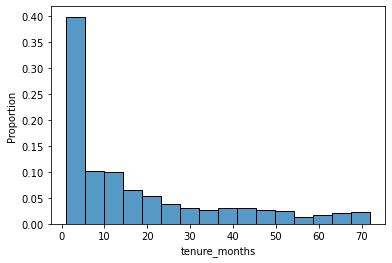

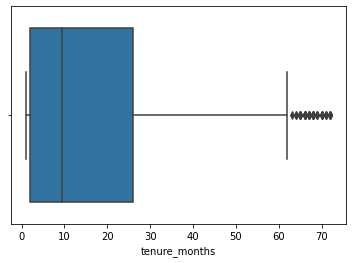

       tenure_months
count        1046.00
mean           17.43
std            19.21
min             1.00
25%             2.00
50%             9.50
75%            26.00
max            72.00
mode:		 1


TENURE_QUARTERS


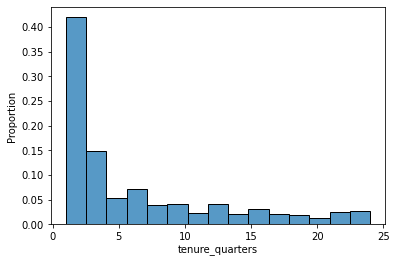

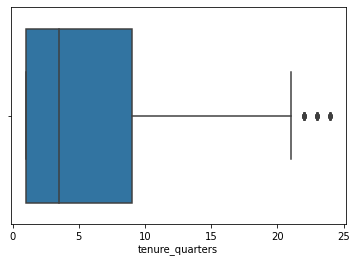

       tenure_quarters
count          1046.00
mean              6.21
std               6.36
min               1.00
25%               1.00
50%               3.50
75%               9.00
max              24.00
mode:		 1


TENURE_YEARS


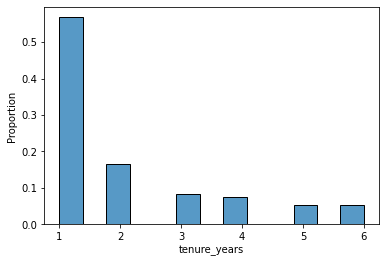

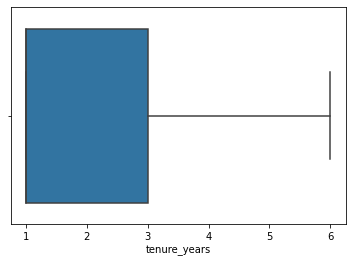

       tenure_years
count       1046.00
mean           2.04
std            1.51
min            1.00
25%            1.00
50%            1.00
75%            3.00
max            6.00
mode:		 1


In [46]:
for col in ['tenure_months', 'tenure_quarters', 'tenure_years']:
    print(line_break)
    print(col.upper())

    # display a histogram of tenure for customers who have churned
    sns.histplot(train[train.churn == 'Yes'][col], stat='proportion')
    plt.show()

    # display a boxplot of months of tenure for customers who have churned
    sns.boxplot(train[train.churn == 'Yes'][col])
    plt.show()

    # display summary statistics for months of tenure for customers who have churned
    print(pd.DataFrame(train[train.churn == 'Yes'][col].describe()))
    
    # display the most common value
    print('mode:\t\t', train[train.churn == 'Yes'][col].mode()[0])

Customers churn most often in their first month, and on average in their 17th month.

Customers churn most often in their first quarter, and on average in their 6th quarter

Customers churn most often in their first year, and on average in their 2nd year. 

The bulk of customers (75%) churn within their first three years. 

### Further Exploration - What month are customers most likely to churn - by contract type

In [47]:
# get the data: 
churned_1yr = train[(train.contract_type == 'One year') & (train.churn == 'Yes')]
churned_2yr = train[(train.contract_type == 'Two year') & (train.churn == 'Yes')]
churned_monthly = train[(train.contract_type == 'Month-to-month') & (train.churn == 'Yes')]



One year


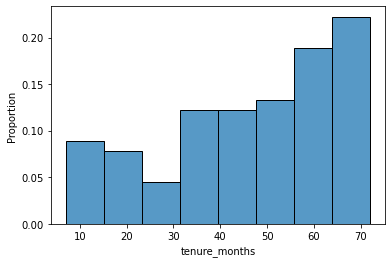

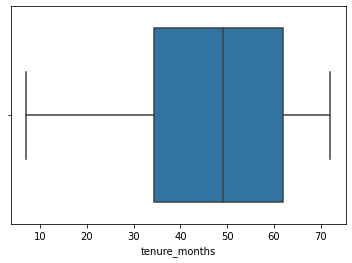

       tenure_months
count          90.00
mean           46.39
std            18.30
min             7.00
25%            34.25
50%            49.00
75%            62.00
max            72.00
mode:		 56


Two year


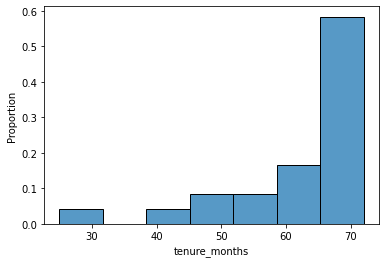

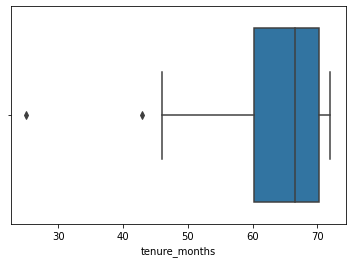

       tenure_months
count          24.00
mean           62.58
std            11.52
min            25.00
25%            60.25
50%            66.50
75%            70.25
max            72.00
mode:		 71


Month-to-month


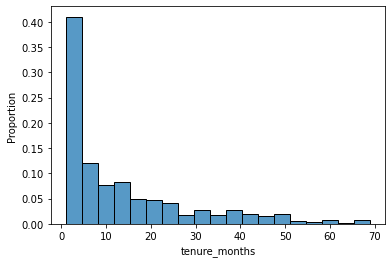

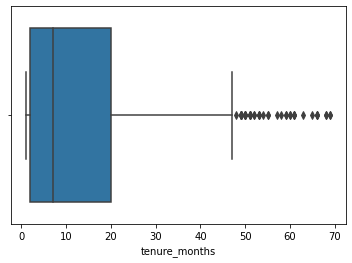

       tenure_months
count         932.00
mean           13.47
std            15.16
min             1.00
25%             2.00
50%             7.00
75%            20.00
max            69.00
mode:		 1


In [48]:
# for each category of contract type
for group in [churned_1yr, churned_2yr, churned_monthly]:
    print(line_break)
    print(group.contract_type.mode()[0])
    
    # display a histogram of months of tenure for that group
    sns.histplot(group.tenure_months, stat='proportion')
    plt.show()
    
    # display a boxplot of months of tenure for that group
    sns.boxplot(group.tenure_months)
    plt.show()
    
    # display summary statistics for moths of tenure for that group
    print(pd.DataFrame(group.tenure_months.describe()))
    
    # display the most common value
    print('mode:\t\t', group.tenure_months.mode()[0])

Here we can see that the distribution of tenure varies significantly between those with monthly contract and those with other contract types. Monthly customers, who we know are most likely to churn, also churn much earlier than their longer-contract counterparts. This should not be surprising, but it is worth noting. 

The average month in which monthly customers churn is their 13th month (while the most common is the 1st month). For yearly and two-year contract customers, the average is the 46th and 62nd month, respectively (most common is 56 and 71). 

### Further Exploration: is there an internet service type associated with more or less churn than expected?
i.e. is the churn rate different for any particular service type vs the overall average?

In [49]:
train.internet_service_type.unique()

array(['Fiber optic', 'None', 'DSL'], dtype=object)

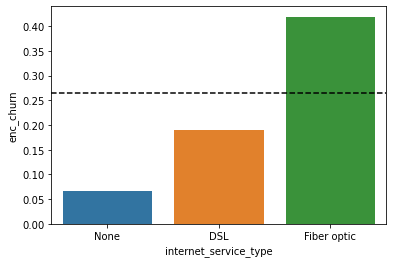

In [50]:
churn_rates = (pd.DataFrame(train.groupby(by='internet_service_type').mean().enc_churn)
               .reset_index()
               .sort_values(by='enc_churn'))
sns.barplot(data = churn_rates,
            x = 'internet_service_type', 
            y = 'enc_churn')
plt.axhline(train.enc_churn.mean(), 
                ls='--', 
                color='black')
plt.show()


#### Is whether a customer has churned independent of their internet service type?

In [51]:
# establish hypotheses

# H0: Whether a customer has churned is independent of their internet service type
# H1: Whether a customer has churned is not independent of their internet service type

# run the test and display results
chi2_test(train.churn, train.internet_service_type)

Observed

[[1114 1013  764]
 [ 260  731   55]]
---
Expected

[[1008.9 1280.6  601.4]
 [ 365.1  463.4  217.6]]
---

chi^2 = 417.1612
p     = 0.0000

Reject H0


Since p is < alpha, we reject the null hypothesis and proceed under the assumption that whether a customer has churned is not independent of their internet service type

# MODELING

### Decision Tree

In [52]:
positive = 1
target = 'enc_churn'

In [53]:
# create empty dataframe to store model results
model_results = pd.DataFrame(columns=['model_number', 'metric_type', 'sample_type', 'score'])

# empty dataframe to store information about the model itself
model_info = pd.DataFrame(columns=['model_number', 'features'])

In [54]:
# identify encoded feature columns
encoded_columns = [col for col in df.columns if (col[:4] == 'enc_') and col != target]

In [55]:
# # make a list of all possible feature combinations
# feature_combos = []
# for i in range (1, len(encoded_columns)+1):
#     feature_combos.extend(list(itertools.combinations(encoded_columns,i)))
# feature_combos = [np.array(combo) for combo in feature_combos]


In [56]:
for col in train.columns:
    print(col)

gender
senior_citizen
partner
dependents
tenure_months
phone_service
multiple_lines
online_security
online_backup
device_protection
tech_support
streaming_tv
streaming_movies
paperless_billing
monthly_charges
churn
contract_type
internet_service_type
payment_type
tenure_quarters
tenure_years
enc_gender_male
enc_senior_citizen_yes
enc_partner_yes
enc_dependents_yes
enc_phone_service_yes
enc_multiple_lines_no phone service
enc_multiple_lines_yes
enc_online_security_no internet service
enc_online_security_yes
enc_online_backup_no internet service
enc_online_backup_yes
enc_device_protection_no internet service
enc_device_protection_yes
enc_tech_support_no internet service
enc_tech_support_yes
enc_streaming_tv_no internet service
enc_streaming_tv_yes
enc_streaming_movies_no internet service
enc_streaming_movies_yes
enc_paperless_billing_yes
enc_churn
enc_contract_type_one year
enc_contract_type_two year
enc_internet_service_type_fiber optic
enc_internet_service_type_none
enc_payment_type_cr

In [57]:
features1 = encoded_columns
features2 = ['enc_gender_male', 
             'enc_senior_citizen_yes', 
             'enc_partner_yes', 
             'enc_dependents_yes', 
             'enc_contract_type_one year', 'enc_contract_type_two year', 
             'enc_internet_service_type_fiber optic', 'enc_internet_service_type_none']
feature_combos = [features1, features2]

In [58]:
# separate each sample into x and y
x_train = train.drop(columns=target)
y_train = train[target]

x_validate = validate.drop(columns=target)
y_validate = validate[target]

x_test = test.drop(columns=target)
y_test = test[target]

# store baseline metrics

model_number = 'baseline'
model_type = 'baseline'

# store info about the model
dct = {'model_number': model_number,
       'model_type': model_type}
model_info = model_info.append(dct, ignore_index=True)

# establish baseline predictions for train sample
y_pred = baseline_pred = pd.Series([train[target].mode()[0]]).repeat(len(train))

# get metrics
dct = {'model_number': model_number, 
       'sample_type': 'train', 
       'metric_type': 'accuracy',
       'score': sk.metrics.accuracy_score(y_train, y_pred)}
model_results = model_results.append(dct, ignore_index=True)

dct = {'model_number': model_number, 
       'sample_type': 'train', 
       'metric_type': 'precision',
       'score': sk.metrics.precision_score(y_train, y_pred, pos_label=positive)}
model_results = model_results.append(dct, ignore_index=True)

dct = {'model_number': model_number, 
       'sample_type': 'train', 
       'metric_type': 'recall',
       'score': sk.metrics.recall_score(y_train, y_pred, pos_label=positive)}
model_results = model_results.append(dct, ignore_index=True)

dct = {'model_number': model_number, 
       'sample_type': 'train', 
       'metric_type': 'f1_score',
       'score': sk.metrics.f1_score(y_train, y_pred, pos_label=positive)}
model_results = model_results.append(dct, ignore_index=True)

# establish baseline predictions for validate sample
y_pred = baseline_pred = pd.Series([train[target].mode()[0]]).repeat(len(validate))

# get metrics
dct = {'model_number': model_number, 
       'sample_type': 'validate', 
       'metric_type': 'f1_score',
       'score': sk.metrics.f1_score(y_validate, y_pred, pos_label=positive)}
model_results = model_results.append(dct, ignore_index=True)

dct = {'model_number': model_number, 
       'sample_type': 'validate', 
       'metric_type': 'accuracy',
       'score': sk.metrics.accuracy_score(y_validate, y_pred)}
model_results = model_results.append(dct, ignore_index=True)

dct = {'model_number': model_number, 
       'sample_type': 'validate', 
       'metric_type': 'precision',
       'score': sk.metrics.precision_score(y_validate, y_pred, pos_label=positive)}
model_results = model_results.append(dct, ignore_index=True)

dct = {'model_number': model_number, 
       'sample_type': 'validate', 
       'metric_type': 'recall',
       'score': sk.metrics.recall_score(y_validate, y_pred, pos_label=positive)}
model_results = model_results.append(dct, ignore_index=True)

model_number = 0

In [59]:
# create models and store results

for features in feature_combos:
    for max_depth in range(1, 11):

        model_number += 1
        model_type = 'decision tree'

        # store info about the model
        dct = {'model_number': model_number,
               'model_type': model_type,
               'features': features,
               'max_depth': max_depth}
        model_info = model_info.append(dct, ignore_index=True)

        # separate each sample into x and y
        x_train = train[features]
        y_train = train[target]

        x_validate = validate[features]
        y_validate = validate[target]


        # create the classifer
        clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

        # fit the classifier to the training data
        clf = clf.fit(x_train, y_train)


        # results for train sample
        y_pred = clf.predict(x_train)
        sample_type = 'train'


        # get metrics
        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'accuracy',
               'score': sk.metrics.accuracy_score(y_train, y_pred)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'precision',
               'score': sk.metrics.precision_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'recall',
               'score': sk.metrics.recall_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'f1_score',
               'score': sk.metrics.f1_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)


        # results for validate sample
        x_train
        y_pred = clf.predict(x_validate)
        sample_type = 'validate'

        # get metrics
        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'f1_score',
               'score': sk.metrics.f1_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'accuracy',
               'score': sk.metrics.accuracy_score(y_validate, y_pred)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'precision',
               'score': sk.metrics.precision_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'recall',
               'score': sk.metrics.recall_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)     

In [60]:
def display_model_results():
    return model_results.pivot_table(columns='model_number', 
                                     index=('metric_type', 'sample_type'), 
                                     values='score',
                                     aggfunc=lambda x: x)

In [61]:
model_info

,model_number,features,model_type,max_depth
0,baseline,NaN,baseline,NaN
1,1,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,1.0
2,2,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,2.0
3,3,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,3.0
4,4,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,4.0
5,5,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,5.0
6,6,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,6.0
7,7,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,7.0
8,8,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,8.0
9,9,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,9.0


In [62]:
display_model_results()

model_number                1     2     3     4     5     6     7     8     9  \
metric_type sample_type                                                         
accuracy    train        0.73  0.76  0.77  0.78  0.79  0.79  0.80  0.81  0.83   
            validate     0.73  0.74  0.75  0.77  0.77  0.76  0.78  0.77  0.77   
f1_score    train        0.00  0.51  0.51  0.52  0.53  0.56  0.60  0.63  0.65   
            validate     0.00  0.46  0.46  0.47  0.49  0.48  0.54  0.54  0.52   
precision   train        0.00  0.55  0.59  0.62  0.64  0.64  0.65  0.67  0.70   
            validate     0.00  0.51  0.55  0.60  0.60  0.56  0.60  0.58  0.57   
recall      train        0.00  0.48  0.45  0.45  0.46  0.49  0.55  0.60  0.61   
            validate     0.00  0.43  0.40  0.39  0.42  0.42  0.50  0.50  0.48   

model_number               10    11    12    13    14    15    16    17    18  \
metric_type sample_type                                                         
accuracy    train        0.84  0.73  0.73  0.76  0.77  0.77  0.77  0.77  0.77   
            validate     0.75  0.73  0.73  0.77  0.76  0.76  0.76  0.75  0.75   
f1_score    train        0.69  0.00  0.00  0.59  0.49  0.53  0.54  0.47  0.47   
            validate     0.52  0.00  0.00  0.58  0.45  0.50  0.51  0.42  0.42   
precision   train        0.72  0.00  0.00  0.55  0.59  0.58  0.58  0.62  0.62   
            validate     0.54  0.00  0.00  0.56  0.57  0.57  0.55  0.57  0.56   
recall      train        0.67  0.00  0.00  0.63  0.42  0.49  0.51  0.37  0.38   
            validate     0.50  0.00  0.00  0.61  0.37  0.45  0.47  0.33  0.33   

model_number               19    20  baseline  
metric_type sample_type                        
accuracy    train        0.77  0.77      0.73  
            validate     0.75  0.75      0.73  
f1_score    train        0.47  0.47      0.00  
            validate     0.42  0.42      0.00  
precision   train        0.62  0.62      0.00  
            validate     0.56  0.56      0.00  
recall      train        0.38  0.38      0.00  
            validate     0.33  0.33      0.00

### Random Forest

In [63]:
for features in feature_combos:
    for max_depth in range(1, 11):
        for min_samples_leaf in range(1, 11):

            model_number += 1

            model_type = 'random forest'

            # store info about the model
            dct = {'model_number': model_number,
                   'model_type': model_type,
                   'features': features,
                   'max_depth': max_depth, 
                   'min_samples_leaf': min_samples_leaf}
            model_info = model_info.append(dct, ignore_index=True)

            # separate each sample into x and y
            x_train = train[features]
            y_train = train[target]

            x_validate = validate[features]
            y_validate = validate[target]


            # create the classifer
            clf = RandomForestClassifier(max_depth=max_depth, 
                                         min_samples_leaf=min_samples_leaf, 
                                         random_state=42)

            # fit the classifier to the training data
            clf = clf.fit(x_train, y_train)


            # results for train sample
            y_pred = clf.predict(x_train)


            # get metrics
            dct = {'model_number': model_number, 
                   'sample_type': 'train', 
                   'metric_type': 'accuracy',
                   'score': sk.metrics.accuracy_score(y_train, y_pred)}
            model_results = model_results.append(dct, ignore_index=True)

            dct = {'model_number': model_number, 
                   'sample_type': 'train', 
                   'metric_type': 'precision',
                   'score': sk.metrics.precision_score(y_train, y_pred, pos_label=positive)}
            model_results = model_results.append(dct, ignore_index=True)

            dct = {'model_number': model_number, 
                   'sample_type': 'train', 
                   'metric_type': 'recall',
                   'score': sk.metrics.recall_score(y_train, y_pred, pos_label=positive)}
            model_results = model_results.append(dct, ignore_index=True)

            dct = {'model_number': model_number, 
                   'sample_type': 'train', 
                   'metric_type': 'f1_score',
                   'score': sk.metrics.f1_score(y_train, y_pred, pos_label=positive)}
            model_results = model_results.append(dct, ignore_index=True)


            # results for validate sample
            x_train
            y_pred = clf.predict(x_validate)

            # get metrics
            dct = {'model_number': model_number, 
                   'sample_type': 'validate', 
                   'metric_type': 'f1_score',
                   'score': sk.metrics.f1_score(y_validate, y_pred, pos_label=positive)}
            model_results = model_results.append(dct, ignore_index=True)

            dct = {'model_number': model_number, 
                   'sample_type': 'validate', 
                   'metric_type': 'accuracy',
                   'score': sk.metrics.accuracy_score(y_validate, y_pred)}
            model_results = model_results.append(dct, ignore_index=True)

            dct = {'model_number': model_number, 
                   'sample_type': 'validate', 
                   'metric_type': 'precision',
                   'score': sk.metrics.precision_score(y_validate, y_pred, pos_label=positive)}
            model_results = model_results.append(dct, ignore_index=True)

            dct = {'model_number': model_number, 
                   'sample_type': 'validate', 
                   'metric_type': 'recall',
                   'score': sk.metrics.recall_score(y_validate, y_pred, pos_label=positive)}
            model_results = model_results.append(dct, ignore_index=True)    

In [64]:
model_info

,model_number,features,model_type,max_depth,min_samples_leaf
0,baseline,NaN,baseline,NaN,NaN
1,1,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,1.0,NaN
2,2,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,2.0,NaN
3,3,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,3.0,NaN
4,4,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,4.0,NaN
5,5,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,5.0,NaN
6,6,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,6.0,NaN
7,7,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,7.0,NaN
8,8,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,8.0,NaN
9,9,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,9.0,NaN


In [65]:
display_model_results()

model_number                1     2     3     4     5     6     7     8     9  \
metric_type sample_type                                                         
accuracy    train        0.73  0.76  0.77  0.78  0.79  0.79  0.80  0.81  0.83   
            validate     0.73  0.74  0.75  0.77  0.77  0.76  0.78  0.77  0.77   
f1_score    train        0.00  0.51  0.51  0.52  0.53  0.56  0.60  0.63  0.65   
            validate     0.00  0.46  0.46  0.47  0.49  0.48  0.54  0.54  0.52   
precision   train        0.00  0.55  0.59  0.62  0.64  0.64  0.65  0.67  0.70   
            validate     0.00  0.51  0.55  0.60  0.60  0.56  0.60  0.58  0.57   
recall      train        0.00  0.48  0.45  0.45  0.46  0.49  0.55  0.60  0.61   
            validate     0.00  0.43  0.40  0.39  0.42  0.42  0.50  0.50  0.48   

model_number               10    11    12    13    14    15    16    17    18  \
metric_type sample_type                                                         
accuracy    train        0.84  0.73  0.73  0.76  0.77  0.77  0.77  0.77  0.77   
            validate     0.75  0.73  0.73  0.77  0.76  0.76  0.76  0.75  0.75   
f1_score    train        0.69  0.00  0.00  0.59  0.49  0.53  0.54  0.47  0.47   
            validate     0.52  0.00  0.00  0.58  0.45  0.50  0.51  0.42  0.42   
precision   train        0.72  0.00  0.00  0.55  0.59  0.58  0.58  0.62  0.62   
            validate     0.54  0.00  0.00  0.56  0.57  0.57  0.55  0.57  0.56   
recall      train        0.67  0.00  0.00  0.63  0.42  0.49  0.51  0.37  0.38   
            validate     0.50  0.00  0.00  0.61  0.37  0.45  0.47  0.33  0.33   

model_number               19    20    21    22    23    24    25    26    27  \
metric_type sample_type                                                         
accuracy    train        0.77  0.77  0.73  0.73  0.73  0.73  0.73  0.73  0.73   
            validate     0.75  0.75  0.73  0.73  0.73  0.73  0.73  0.73  0.73   
f1_score    train        0.47  0.47  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.42  0.42  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
precision   train        0.62  0.62  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.56  0.56  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
recall      train        0.38  0.38  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.33  0.33  0.00  0.00  0.00  0.00  0.00  0.00  0.00   

model_number               28    29    30    31    32    33    34    35    36  \
metric_type sample_type                                                         
accuracy    train        0.73  0.73  0.73  0.73  0.73  0.73  0.73  0.73  0.73   
            validate     0.73  0.73  0.73  0.73  0.73  0.73  0.73  0.73  0.73   
f1_score    train        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
precision   train        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
recall      train        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   

model_number               37    38    39    40    41    42    43    44    45  \
metric_type sample_type                                                         
accuracy    train        0.73  0.73  0.73  0.73  0.74  0.74  0.74  0.74  0.74   
            validate     0.73  0.73  0.73  0.73  0.74  0.74  0.74  0.74  0.74   
f1_score    train        0.00  0.00  0.00  0.00  0.10  0.10  0.10  0.10  0.10   
            validate     0.00  0.00  0.00  0.00  0.08  0.08  0.08  0.08  0.08   
precision   train        0.00  0.00  0.00  0.00  0.79  0.79  0.79  0.79  0.79   
            validate     0.00  0.00  0.00  0.00  0.70  0.70  0.70  0.70  0.70   
recall      train        0.00  0.00  0.00  0.00  0.05  0.05  0.05  0.05  0.05   
            validate     0.

### KNN

In [66]:
for features in feature_combos:    
    for k_neighbors in range(1, 11):

        model_number += 1

        model_type = 'KNN'

        # store info about the model
        dct = {'model_number': model_number,
               'model_type': model_type,
               'features': features,
               'k-neighbors': k_neighbors}
        model_info = model_info.append(dct, ignore_index=True)

        # separate each sample into x and y
        x_train = train[features]
        y_train = train[target]

        x_validate = validate[features]
        y_validate = validate[target]


        # create the classifer
        clf = KNeighborsClassifier(n_neighbors=k_neighbors)

        # fit the classifier to the training data
        clf = clf.fit(x_train, y_train)


        # results for train sample
        y_pred = clf.predict(x_train)


        # get metrics
        dct = {'model_number': model_number, 
               'sample_type': 'train', 
               'metric_type': 'accuracy',
               'score': sk.metrics.accuracy_score(y_train, y_pred)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'train', 
               'metric_type': 'precision',
               'score': sk.metrics.precision_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'train', 
               'metric_type': 'recall',
               'score': sk.metrics.recall_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'train', 
               'metric_type': 'f1_score',
               'score': sk.metrics.f1_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)


        # results for validate sample
        x_train
        y_pred = clf.predict(x_validate)

        # get metrics
        dct = {'model_number': model_number, 
               'sample_type': 'validate', 
               'metric_type': 'f1_score',
               'score': sk.metrics.f1_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'validate', 
               'metric_type': 'accuracy',
               'score': sk.metrics.accuracy_score(y_validate, y_pred)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'validate', 
               'metric_type': 'precision',
               'score': sk.metrics.precision_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'validate', 
               'metric_type': 'recall',
               'score': sk.metrics.recall_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)    

In [67]:
model_info

,model_number,features,model_type,max_depth,min_samples_leaf,k-neighbors
0,baseline,NaN,baseline,NaN,NaN,NaN
1,1,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,1.0,NaN,NaN
2,2,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,2.0,NaN,NaN
3,3,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,3.0,NaN,NaN
4,4,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,4.0,NaN,NaN
5,5,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,5.0,NaN,NaN
6,6,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,6.0,NaN,NaN
7,7,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,7.0,NaN,NaN
8,8,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,8.0,NaN,NaN
9,9,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,9.0,NaN,NaN


In [68]:
display_model_results()

model_number                1     2     3     4     5     6     7     8     9  \
metric_type sample_type                                                         
accuracy    train        0.73  0.76  0.77  0.78  0.79  0.79  0.80  0.81  0.83   
            validate     0.73  0.74  0.75  0.77  0.77  0.76  0.78  0.77  0.77   
f1_score    train        0.00  0.51  0.51  0.52  0.53  0.56  0.60  0.63  0.65   
            validate     0.00  0.46  0.46  0.47  0.49  0.48  0.54  0.54  0.52   
precision   train        0.00  0.55  0.59  0.62  0.64  0.64  0.65  0.67  0.70   
            validate     0.00  0.51  0.55  0.60  0.60  0.56  0.60  0.58  0.57   
recall      train        0.00  0.48  0.45  0.45  0.46  0.49  0.55  0.60  0.61   
            validate     0.00  0.43  0.40  0.39  0.42  0.42  0.50  0.50  0.48   

model_number               10    11    12    13    14    15    16    17    18  \
metric_type sample_type                                                         
accuracy    train        0.84  0.73  0.73  0.76  0.77  0.77  0.77  0.77  0.77   
            validate     0.75  0.73  0.73  0.77  0.76  0.76  0.76  0.75  0.75   
f1_score    train        0.69  0.00  0.00  0.59  0.49  0.53  0.54  0.47  0.47   
            validate     0.52  0.00  0.00  0.58  0.45  0.50  0.51  0.42  0.42   
precision   train        0.72  0.00  0.00  0.55  0.59  0.58  0.58  0.62  0.62   
            validate     0.54  0.00  0.00  0.56  0.57  0.57  0.55  0.57  0.56   
recall      train        0.67  0.00  0.00  0.63  0.42  0.49  0.51  0.37  0.38   
            validate     0.50  0.00  0.00  0.61  0.37  0.45  0.47  0.33  0.33   

model_number               19    20    21    22    23    24    25    26    27  \
metric_type sample_type                                                         
accuracy    train        0.77  0.77  0.73  0.73  0.73  0.73  0.73  0.73  0.73   
            validate     0.75  0.75  0.73  0.73  0.73  0.73  0.73  0.73  0.73   
f1_score    train        0.47  0.47  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.42  0.42  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
precision   train        0.62  0.62  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.56  0.56  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
recall      train        0.38  0.38  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.33  0.33  0.00  0.00  0.00  0.00  0.00  0.00  0.00   

model_number               28    29    30    31    32    33    34    35    36  \
metric_type sample_type                                                         
accuracy    train        0.73  0.73  0.73  0.73  0.73  0.73  0.73  0.73  0.73   
            validate     0.73  0.73  0.73  0.73  0.73  0.73  0.73  0.73  0.73   
f1_score    train        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
precision   train        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
recall      train        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   

model_number               37    38    39    40    41    42    43    44    45  \
metric_type sample_type                                                         
accuracy    train        0.73  0.73  0.73  0.73  0.74  0.74  0.74  0.74  0.74   
            validate     0.73  0.73  0.73  0.73  0.74  0.74  0.74  0.74  0.74   
f1_score    train        0.00  0.00  0.00  0.00  0.10  0.10  0.10  0.10  0.10   
            validate     0.00  0.00  0.00  0.00  0.08  0.08  0.08  0.08  0.08   
precision   train        0.00  0.00  0.00  0.00  0.79  0.79  0.79  0.79  0.79   
            validate     0.00  0.00  0.00  0.00  0.70  0.70  0.70  0.70  0.70   
recall      train        0.00  0.00  0.00  0.00  0.05  0.05  0.05  0.05  0.05   
            validate     0.

### Logistic Regression

In [69]:
for features in feature_combos:    
    for c_value in [.001, .01, .1, 1, 10, 100, 1000]:

        model_number += 1

        model_type = 'logistic regression'

        # store info about the model
        dct = {'model_number': model_number,
               'model_type': model_type,
               'features': features,
               'c_value': c_value}
        model_info = model_info.append(dct, ignore_index=True)

        # separate each sample into x and y
        x_train = train[features]
        y_train = train[target]

        x_validate = validate[features]
        y_validate = validate[target]


        # create the classifier
        clf = LogisticRegression(C=c_value)

        # fit the classifier to the training data
        clf = clf.fit(x_train, y_train)


        # results for train sample
        y_pred = clf.predict(x_train)


        # get metrics
        dct = {'model_number': model_number, 
               'sample_type': 'train', 
               'metric_type': 'accuracy',
               'score': sk.metrics.accuracy_score(y_train, y_pred)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'train', 
               'metric_type': 'precision',
               'score': sk.metrics.precision_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'train', 
               'metric_type': 'recall',
               'score': sk.metrics.recall_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'train', 
               'metric_type': 'f1_score',
               'score': sk.metrics.f1_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)


        # results for validate sample
        x_train
        y_pred = clf.predict(x_validate)

        # get metrics
        dct = {'model_number': model_number, 
               'sample_type': 'validate', 
               'metric_type': 'f1_score',
               'score': sk.metrics.f1_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'validate', 
               'metric_type': 'accuracy',
               'score': sk.metrics.accuracy_score(y_validate, y_pred)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'validate', 
               'metric_type': 'precision',
               'score': sk.metrics.precision_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'validate', 
               'metric_type': 'recall',
               'score': sk.metrics.recall_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)    

In [70]:
model_info

,model_number,features,model_type,max_depth,min_samples_leaf,k-neighbors,c_value
0,baseline,NaN,baseline,NaN,NaN,NaN,NaN
1,1,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,1.0,NaN,NaN,NaN
2,2,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,2.0,NaN,NaN,NaN
3,3,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,3.0,NaN,NaN,NaN
4,4,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,4.0,NaN,NaN,NaN
5,5,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,5.0,NaN,NaN,NaN
6,6,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,6.0,NaN,NaN,NaN
7,7,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,7.0,NaN,NaN,NaN
8,8,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,8.0,NaN,NaN,NaN
9,9,"[enc_gender_male, enc_senior_citizen_yes, enc_partner_yes, enc_dependents_yes, enc_pho...",decision tree,9.0,NaN,NaN,NaN


In [71]:
display_model_results()

model_number                1     2     3     4     5     6     7     8     9  \
metric_type sample_type                                                         
accuracy    train        0.73  0.76  0.77  0.78  0.79  0.79  0.80  0.81  0.83   
            validate     0.73  0.74  0.75  0.77  0.77  0.76  0.78  0.77  0.77   
f1_score    train        0.00  0.51  0.51  0.52  0.53  0.56  0.60  0.63  0.65   
            validate     0.00  0.46  0.46  0.47  0.49  0.48  0.54  0.54  0.52   
precision   train        0.00  0.55  0.59  0.62  0.64  0.64  0.65  0.67  0.70   
            validate     0.00  0.51  0.55  0.60  0.60  0.56  0.60  0.58  0.57   
recall      train        0.00  0.48  0.45  0.45  0.46  0.49  0.55  0.60  0.61   
            validate     0.00  0.43  0.40  0.39  0.42  0.42  0.50  0.50  0.48   

model_number               10    11    12    13    14    15    16    17    18  \
metric_type sample_type                                                         
accuracy    train        0.84  0.73  0.73  0.76  0.77  0.77  0.77  0.77  0.77   
            validate     0.75  0.73  0.73  0.77  0.76  0.76  0.76  0.75  0.75   
f1_score    train        0.69  0.00  0.00  0.59  0.49  0.53  0.54  0.47  0.47   
            validate     0.52  0.00  0.00  0.58  0.45  0.50  0.51  0.42  0.42   
precision   train        0.72  0.00  0.00  0.55  0.59  0.58  0.58  0.62  0.62   
            validate     0.54  0.00  0.00  0.56  0.57  0.57  0.55  0.57  0.56   
recall      train        0.67  0.00  0.00  0.63  0.42  0.49  0.51  0.37  0.38   
            validate     0.50  0.00  0.00  0.61  0.37  0.45  0.47  0.33  0.33   

model_number               19    20    21    22    23    24    25    26    27  \
metric_type sample_type                                                         
accuracy    train        0.77  0.77  0.73  0.73  0.73  0.73  0.73  0.73  0.73   
            validate     0.75  0.75  0.73  0.73  0.73  0.73  0.73  0.73  0.73   
f1_score    train        0.47  0.47  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.42  0.42  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
precision   train        0.62  0.62  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.56  0.56  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
recall      train        0.38  0.38  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.33  0.33  0.00  0.00  0.00  0.00  0.00  0.00  0.00   

model_number               28    29    30    31    32    33    34    35    36  \
metric_type sample_type                                                         
accuracy    train        0.73  0.73  0.73  0.73  0.73  0.73  0.73  0.73  0.73   
            validate     0.73  0.73  0.73  0.73  0.73  0.73  0.73  0.73  0.73   
f1_score    train        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
precision   train        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
recall      train        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
            validate     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   

model_number               37    38    39    40    41    42    43    44    45  \
metric_type sample_type                                                         
accuracy    train        0.73  0.73  0.73  0.73  0.74  0.74  0.74  0.74  0.74   
            validate     0.73  0.73  0.73  0.73  0.74  0.74  0.74  0.74  0.74   
f1_score    train        0.00  0.00  0.00  0.00  0.10  0.10  0.10  0.10  0.10   
            validate     0.00  0.00  0.00  0.00  0.08  0.08  0.08  0.08  0.08   
precision   train        0.00  0.00  0.00  0.00  0.79  0.79  0.79  0.79  0.79   
            validate     0.00  0.00  0.00  0.00  0.70  0.70  0.70  0.70  0.70   
recall      train        0.00  0.00  0.00  0.00  0.05  0.05  0.05  0.05  0.05   
            validate     0.

In [72]:
train_accuracy = model_results[(model_results.sample_type == 'train') & (model_results.metric_type == 'accuracy')]
train_accuracy[train_accuracy.score == train_accuracy.score.max()]

,model_number,metric_type,sample_type,score
1768,221,accuracy,train,0.91


In [73]:
validate_accuracy = model_results[(model_results.sample_type == 'validate') & (model_results.metric_type == 'accuracy')]
validate_accuracy[validate_accuracy.score == validate_accuracy.score.max()]

,model_number,metric_type,sample_type,score
861,107,accuracy,validate,0.78


In [74]:
df.head()

,gender,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,churn,contract_type,internet_service_type,payment_type,tenure_quarters,tenure_years,enc_gender_male,enc_senior_citizen_yes,enc_partner_yes,enc_dependents_yes,enc_phone_service_yes,enc_multiple_lines_no phone service,enc_multiple_lines_yes,enc_online_security_no internet service,enc_online_security_yes,enc_online_backup_no internet service,enc_online_backup_yes,enc_device_protection_no internet service,enc_device_protection_yes,enc_tech_support_no internet service,enc_tech_support_yes,enc_streaming_tv_no internet service,enc_streaming_tv_yes,enc_streaming_movies_no internet service,enc_streaming_movies_yes,enc_paperless_billing_yes,enc_churn,enc_contract_type_one year,enc_contract_type_two year,enc_internet_service_type_fiber optic,enc_internet_service_type_none,enc_payment_type_credit card (automatic),enc_payment_type_electronic check,enc_payment_type_mailed check
0,Female,No,Yes,Yes,9,Yes,No,No,Yes,No,Yes,Yes,No,Yes,65.6,No,One year,DSL,Mailed check,3,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1
1,Male,No,No,No,9,Yes,Yes,No,No,No,No,No,Yes,No,59.9,No,Month-to-month,DSL,Mailed check,3,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,Male,No,No,No,4,Yes,No,No,No,Yes,No,No,No,Yes,73.9,Yes,Month-to-month,Fiber optic,Electronic check,2,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0
3,Male,Yes,Yes,No,13,Yes,No,No,Yes,Yes,No,Yes,Yes,Yes,98.0,Yes,Month-to-month,Fiber optic,Electronic check,5,2,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,1,0,0,1,0
4,Female,Yes,Yes,No,3,Yes,No,No,No,No,Yes,Yes,No,Yes,83.9,Yes,Month-to-month,Fiber optic,Mailed check,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,1


### Modeling - Final Test

Now, we will take our best performing model (#107) and see how it performs on our `test` sample. This will approximate the expected performance of this model in predicting the churn for additional customers in the real-world. 

In [75]:
# re-creating the model using the given features and hyperparameters

# separate each sample into x (features) and y (target)
x_train = train[features1]
y_train = train[target]

x_test = test[features1]
y_test = test[target]

# create the classifier

# a random forest classifier with the given max-depth and min-samples-leaf values
# establish a random state for produceability
clf = RandomForestClassifier(max_depth=9, 
                             min_samples_leaf=7, 
                             random_state=42)

# fit the classifier to the training data
clf = clf.fit(x_train, y_train)

# create predictions for the model's performance on the test set
y_pred = clf.predict(x_test)

# establish the probability for those predictions created above
y_pred_proba = clf.predict_proba(x_test)[:,1]

# exporting the predictions and prediction probabilities for test sample into a .csv for delivery

# create a dataframe with the appropriate columns
predictions = pd.DataFrame(columns=['customer_id', 'churn_probability', 'churn_prediction'])
# set customer id using the customer_id column from the original database
predictions['customer_id'] = test.customer_id
# set the churn_probability column using the probabilities created above
predictions['churn_probability'] = y_pred_proba
# set the predictions column using the predictions created above
predictions['churn_prediction'] = y_pred
# write to a local csv file
predictions.to_csv('predictions.csv')

AttributeError: 'DataFrame' object has no attribute 'customer_id'